<a href="https://colab.research.google.com/github/vniranjan26/Haberman_Survival/blob/main/habermanSurvival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy import stats

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import brier_score_loss, make_scorer

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
import seaborn as sns
from sklearn.model_selection import GridSearchCV
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper")
#plt.style.use('whitegrid')

<h3><center>1. Reading Data </center></h3>

In [26]:
FILE_PATH = 'https://drive.google.com/uc?export=download&id=1V_jmQE01OZtkcSM1r8_grUoFDLyRmDuk'
columns = ['age', 'year', 'nodes', 'class']

haberman_df = pd.read_csv(FILE_PATH, header=None, names=columns)

# Setting class values to 1 & 0 for +ve & -ve classes
haberman_df['class'].replace({1:0,2:1}, inplace=True)
haberman_df.sample(5)

,age,year,nodes,class
21,37,59,6,0
40,40,58,2,0
151,52,62,0,0
140,51,65,0,0
146,52,61,0,0


<h3><center>2. Exploring Data </center></h3>

In [27]:
DataDesc(haberman_df)

Dataset Shape: (306, 4)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,age,int64,0,49,30,30,30,5.34
1,year,int64,0,12,64,62,65,3.53
2,nodes,int64,0,31,1,3,0,3.19
3,class,int64,0,2,0,0,0,0.83


<h3>2.1. Age Distribution & Outliers</h3>

count    306.000000
mean      52.457516
std       10.803452
min       30.000000
25%       44.000000
50%       52.000000
75%       60.750000
max       83.000000
Name: age, dtype: float64



Lower outliers: 0
Upper outliers: 0
Total outliers: 0
Non - outliers: 306
% of Outliers : 0.0


None

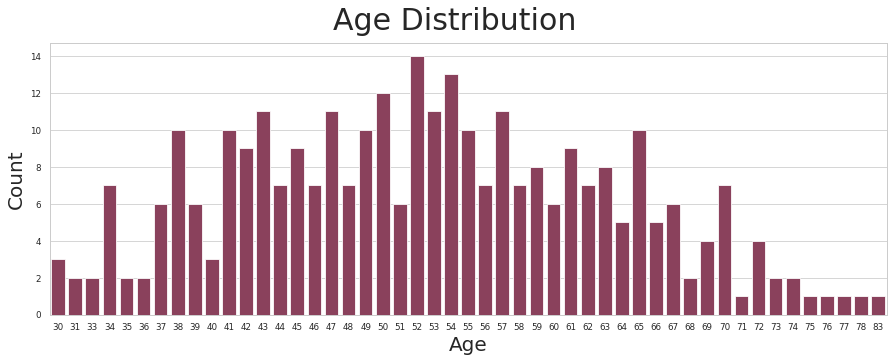

In [28]:
display(haberman_df['age'].describe())

plt.figure(figsize=(15,5))
plt.suptitle('Age Distribution', fontsize=30)
_ = sns.countplot(data=haberman_df, x='age', color='#963559')
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xlabel('Age', fontsize=20)


print("\n")
display(CalOutliers(haberman_df['age']))

<div style="font-family:verdana; word-spacing:1.5px;">
<h4 style="font-family:verdana; word-spacing:1.5px;font-size:16px">Analysis of feature "Age" :</h4>
<ul><li>Entropy/Uncertainty of column age is the highest(5.34), having 49 unique values out of 306 total samples.
    <li>Mean age value is 52 and the distribution is similar to a normal Distribution.
        <li> As of now we have not detected any outliers using naive calculation.
    </ul>
</div>

<h3>2.2 Distribution of Age Based on Cancer</h3>

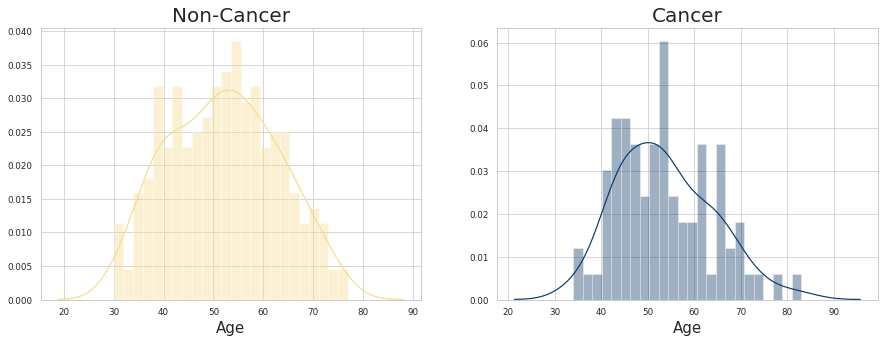

In [29]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
_ = sns.distplot(haberman_df[haberman_df['class'] == 0]['age'], bins=24, color='#f5dd90', ax=ax1)
_ = ax1.set_title('Non-Cancer', fontsize=20)
_ = ax1.set_xlabel("Age",fontsize=15)
_ = ax1.set_ylabel("")

ax2 = fig.add_subplot(122)
_ = sns.distplot(haberman_df[haberman_df['class'] == 1]['age'], bins=24, color='#0d3b66', ax=ax2)
_ = ax2.set_title('Cancer', fontsize=20)
_ = ax2.set_xlabel("Age",fontsize=15)
_ = ax2.set_ylabel("")

<h3>2.3 Nodes Distribution</h3>

count    306.000000
mean       4.026144
std        7.189654
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       52.000000
Name: nodes, dtype: float64



Lower outliers: 0
Upper outliers: 5
Total outliers: 5
Non - outliers: 301
% of Outliers : 1.6611


None

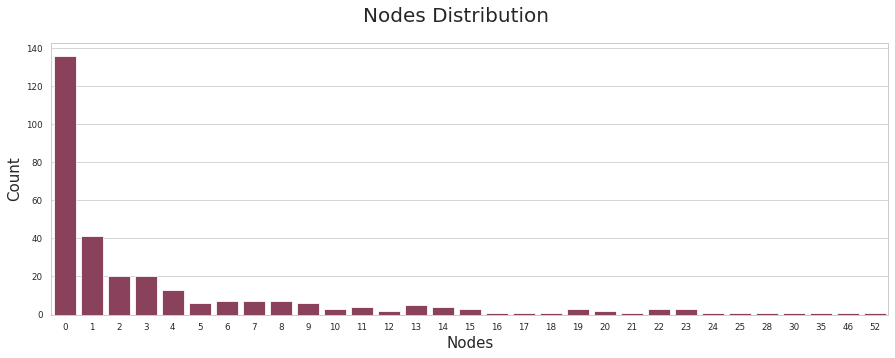

In [30]:
display(haberman_df['nodes'].describe())

plt.figure(figsize=(15,5))
plt.suptitle('Nodes Distribution', fontsize=20)
_ = sns.countplot(data=haberman_df, x='nodes', color='#963559')
_ = plt.ylabel('Count', fontsize=15)
_ = plt.xlabel('Nodes', fontsize=15)


print("\n")
display(CalOutliers(haberman_df['nodes']))

<h3>2.4 Distribution of nodes Based on Cancer</h3>

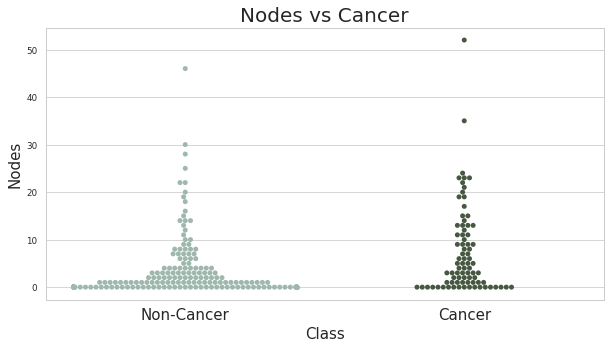

In [31]:
plt.figure(figsize=(10,5))
_ = sns.swarmplot(data=haberman_df, x='class', y='nodes', palette=['#9fb8ad','#475841'])
_ = plt.ylabel('Nodes', fontsize=15)
_ = plt.xlabel('Class', fontsize=15)
_ = plt.xticks([0,1],['Non-Cancer','Cancer'], fontsize=15)
_ = plt.title('Nodes vs Cancer', fontsize=20)

A cancer patient cannot be directly identified by number of nodes

<h3>2.5 Cancer vs Non-Cancer</h3>

Class=0, Count=225, Percentage=73.529%
Class=1, Count=81, Percentage=26.471%


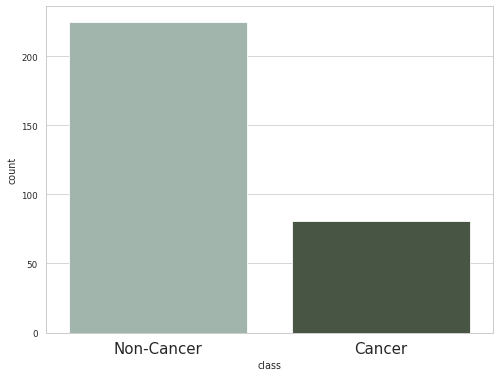

In [32]:
_ = plt.figure(figsize=(8,6))
_ = sns.countplot(haberman_df['class'], palette=['#9fb8ad','#475841'])
_ = plt.xticks([0,1],['Non-Cancer','Cancer'], fontsize=15)

target = haberman_df['class'].values
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

<h3><center>3. Model Test and Baseline Result</center></h3>

<div style="font-family:verdana; word-spacing:1.5px;font-size:16px">
We are interested in predicting a probability of survival, we need a performance metric that evaluates the skill of a model based on the predicted probabilities. In this case, we will use the Brier score that calculates the mean squared error between the predicted probabilities and the expected probabilities.<br><br><br>
    We need a Brier score for a reference prediction. A reference prediction for a problem in which we are predicting probabilities is the probability of the positive class label in the dataset. In this case, the positive class label represents non-survival and occurs about 26% in the dataset. Therefore, predicting about 0.26471 represents the worst-case or baseline performance for a predictive model on this dataset. Any model that has a Brier score better than this has some skill, where as any model that as a Brier score lower than this has no skill.<br><br>
    We will evaluate the baseline strategy of predicting the distribution of positive examples in the training set as the probability of each case in the test set.<br> This can be implemented automatically using the DummyClassifier class and setting the strategy to ‘prior’ that will predict the prior probability of each class in the training dataset, which for the positive class we know is about 0.26471.
    </div>

In [33]:
def brier_skill_score(y_true, y_prob):
    ref_probs = [0.26471 for _ in range(len(y_true))]
    
    bs_ref = brier_score_loss(y_true, ref_probs)
    bs_model = brier_score_loss(y_true, y_prob)
    
    return 1.0 - (bs_model / bs_ref)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    metric = make_scorer(brier_skill_score, needs_proba=True)
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
    
    return scores

In [34]:
X, y = haberman_df.values[:,:-1], haberman_df.values[:,-1]  

model = DummyClassifier(strategy='prior')

scores = evaluate_model(X, y, model)

print(f'Mean BSS {np.mean(scores)}')

Mean BSS -0.00010483367619751327


<h3><center>4. Evaluate Probabilistic Models</center></h3>
<div style="font-family:verdana; word-spacing:1.5px;font-size:16px">
    <ul>
        <li>Logistic Regression (LR)
        <li>Gaussian Naive Bayes (GNB)
        <li>Multinomial Naive Bayes (MNB)
     </ul>
</div>

<h3>4.1. Probabilistic Algorithm Evaluation</h3>

In [46]:
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='lbfgs')) 
    names.append('LR')
    
    models.append(GaussianNB()) 
    names.append('GNB')
    
    models.append(MultinomialNB()) 
    names.append('MNB')
    
    return models, names

In [47]:
models, names = get_models() 
results = list()

for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)

    print('Model : %s, Mean : %.3f, STD : %.3f' % (names[i], np.mean(scores), np.std(scores)))

Model : LR, Mean : 0.060, STD : 0.143
Model : GNB, Mean : 0.012, STD : 0.212
Model : MNB, Mean : -0.211, STD : 0.369


<h3>4.2. Model Evaluation With Scaled Inputs </h3>

In [48]:
models, names = get_models() 
results = list()

for i in range(len(models)):
    steps = [('t',StandardScaler()),('m',models[i])]
    pipeline = Pipeline(steps=steps)
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)

    print('Model : %s, Mean : %.3f, STD : %.3f' % (names[i], np.mean(scores), np.std(scores)))

Model : LR, Mean : 0.062, STD : 0.140
Model : GNB, Mean : 0.012, STD : 0.212
Model : MNB, Mean : nan, STD : nan


<h3>4.3. Model Evaluation With Power Transform</h3>
<div style="font-family:verdana; word-spacing:1.5px;font-size:16px">
Power transforms, such as the Box-Cox and Yeo-Johnson transforms, are designed to change the distribution to be more Gaussian. This will help with the age input variable in our dataset and may help with the nodes variable and un-bunch the distribution slightly.<br><br>
The power transform may make use of a log() function, which does not work on zero values. We have zero values in our dataset, therefore we will scale the dataset prior to the power transform using a MinMaxScaler.</div>

In [49]:
models, names = get_models() 
results = list()

for i in range(len(models)):
    steps = [('scale',MinMaxScaler()),('powert',PowerTransformer()),('model',models[i])]
    pipeline = Pipeline(steps=steps)
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)

    print('Model : %s, Mean : %.3f, STD : %.3f' % (names[i], np.mean(scores), np.std(scores)))


Model : LR, Mean : 0.110, STD : 0.142
Model : GNB, Mean : 0.097, STD : 0.172
Model : MNB, Mean : nan, STD : nan


<h3><center>5. Selecting Logistic regression & Fitting</center></h3>

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

model = LogisticRegression(solver='lbfgs')

steps = [('scaler',MinMaxScaler()), ('powert',PowerTransformer()), ('model',model)]
pipeline = Pipeline(steps=steps)

c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(model__C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [51]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.768430 using {'model__C': 1.0}


<h3>Prediction</h3>

In [52]:
best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[19  4]
 [ 8  0]]
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        23
           1       0.00      0.00      0.00         8

    accuracy                           0.61        31
   macro avg       0.35      0.41      0.38        31
weighted avg       0.52      0.61      0.56        31



<blockquote> Predictions are very poor especially for the positive class making all the predictions wrong</blockquote>

<h3>Using Heuristic(balanced) classw weights in Logistic regression</h3>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

model = LogisticRegression(solver='lbfgs', class_weight='balanced')

steps = [('scaler',MinMaxScaler()), ('powert',PowerTransformer()), ('model',model)]
pipeline = Pipeline(steps=steps)

c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(model__C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


grid_search = GridSearchCV(estimator=pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.719797 using {'model__C': 1.0}


In [43]:
best_model = grid_result.best_estimator_

y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[14  9]
 [ 4  4]]
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.31      0.50      0.38         8

    accuracy                           0.58        31
   macro avg       0.54      0.55      0.53        31
weighted avg       0.66      0.58      0.60        31



<h3>Predicting Probablities</h3>

In [44]:
#Survival Cases
print('Survival Cases:')
data = [[31,59,2], [31,65,4], [34,60,1]]
for row in data:
    yhat = best_model.predict_proba([row])
    p_survive = yhat[0, 0] * 100
    print('>data=%s, Survival=%.3f%%' % (row, p_survive)) 


# some non-survival cases
print('Non-Survival Cases:')
data = [[44,64,6], [34,66,9], [38,69,21]]

for row in data:
    yhat = best_model.predict_proba([row])
    p_survive = yhat[0, 0] * 100
    print('>data=%s, Survival=%.3f%%' % (row, p_survive))

Survival Cases:
>data=[31, 59, 2], Survival=67.315%
>data=[31, 65, 4], Survival=54.731%
>data=[34, 60, 1], Survival=72.910%
Non-Survival Cases:
>data=[44, 64, 6], Survival=36.671%
>data=[34, 66, 9], Survival=36.238%
>data=[38, 69, 21], Survival=25.745%
